# Comment number change by hour

In [ ]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda-client==1.7.2=py37_0
  - defaults/noarch::anaconda-project==0.8.4=py_0
  - defaults/linux-64::bokeh==1.4.0=py37_0
  - defaults/noarch::dask==2.11.0=py_0
  - defaults/linux-64::distributed==2.11.0=py37_0
  - defaults/linux-64::spyder==4.0.1=py37_0
  - defaults/linux-64::watchdog==0.10.2=py37_0
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda-client==1.7.2=py37_0
  - defaults/noarch::anaconda-project==0.8.4=py_0
  - defaults/linux-64::bokeh==1.4.0=py37_0
  - defaults/noarch::dask==2.11.0=py_0
  - defaults/

In [ ]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

3.2.0


## Process S3 data with SageMaker Processing Job `PySparkProcessor`

We are going to move the above processing code in a Python file and then submit that file to SageMaker Processing Job's [`PySparkProcessor`](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html#pysparkprocessor).

In [ ]:
!mkdir -p ./code

In [ ]:
%%writefile ./code/process.py

import os
import logging
import argparse

# Import pyspark and build Spark session
from pyspark.sql.functions import *
from pyspark.sql.types import (
    DoubleType,
    IntegerType,
    StringType,
    StructField,
    StructType,
)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():
    parser = argparse.ArgumentParser(description="app inputs and outputs")
    parser.add_argument("--s3_dataset_path", type=str, help="Path of dataset in S3")
    parser.add_argument("--s3_output_bucket", type=str, help="s3 output bucket")
    parser.add_argument("--s3_output_prefix", type=str, help="s3 output prefix")
    parser.add_argument("--col_name_for_filtering", type=str, help="Name of the column to filter")
    parser.add_argument("--values_to_keep", type=str, help="comma separated list of values to keep in the filtered set")
    args = parser.parse_args()

    spark = SparkSession.builder.appName("PySparkApp").getOrCreate()
    logger.info(f"spark version = {spark.version}")

    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )


    # Downloading the data from S3 into a Dataframe
    logger.info(f"going to read {args.s3_dataset_path}")
    df = spark.read.parquet(args.s3_dataset_path, header=True)
    logger.info(f"finished reading files...")



    # filter the dataframe to only keep the values of interest
    vals = [s.strip() for s in args.values_to_keep.split(",")]
    df_filtered = df.where(col(args.col_name_for_filtering).isin(vals))

    # save the filtered dataframes so that these files can now be used for future analysis
    s3_path = f"s3://{args.s3_output_bucket}/{args.s3_output_prefix}"
    logger.info(f"going to write data for {vals} in {s3_path}")
    logger.info(f"shape of the df_filtered dataframe is {df_filtered.count():,}x{len(df_filtered.columns)}")
    df_filtered.write.mode("overwrite").parquet(s3_path)

    logger.info(f"all done...")

if __name__ == "__main__":
    main()

Overwriting ./code/process.py


Now submit this code to SageMaker Processing Job.

In [ ]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=3600,
)

# s3 paths
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_logs = f"spark_logs"

# modify this comma separated list to choose the subreddits of interest
subreddits = "soccer"
configuration = [
    {
        "Classification": "spark-defaults",
        "Properties": {"spark.executor.memory": "12g", "spark.executor.cores": "4"},
    }
]

# the dataset contains data for these 3 years
year_list = [2023]

CPU times: user 2.36 s, sys: 208 ms, total: 2.57 s
Wall time: 2.75 s


In [ ]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_comments = "project/comments/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
#s3_path = "s3a://sagemaker-us-east-1-038932893404/project/comments/yyyy=2021/part-00000-90796409-5783-4705-92c0-27c27eda8c4c-c000.snappy.parquet"
print(f"reading comments from {s3_path}")
comments = spark.read.parquet(s3_path, header=True)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")

reading comments from s3a://sagemaker-us-east-1-019290627849/project/comments/yyyy=*
shape of the comments dataframe is 2,255,511x21
CPU times: user 186 ms, sys: 30.9 ms, total: 217 ms
Wall time: 5min 29s


In [ ]:
df_soccer = comments.filter(comments["subreddit"] == "soccer").\
    select("body", "created_utc").cache()

In [ ]:
# Generate a column indicating the hour of posts

from pyspark.sql.functions import col, hour

df_soccer = df_soccer.withColumn("hour", hour(col("created_utc"))).cache()

In [ ]:
df_soccer.groupBy('hour').count().show()

+----+------+
|hour| count|
+----+------+
|  12| 89497|
|  22|136043|
|  13|107909|
|  16|148760|
|   6| 23657|
|   3| 26969|
|  20|192923|
|   5| 22119|
|  19|143751|
|  15|144369|
|  17|157456|
|   9| 48708|
|   4| 23954|
|   8| 36536|
|  23| 75739|
|   7| 28692|
|  10| 60532|
|  21|221815|
|  11| 73293|
|  14|147119|
+----+------+
only showing top 20 rows



In [ ]:
hour_count = df_soccer.groupBy('hour').count().toPandas()

In [ ]:
hour_count = hour_count.sort_values(by='hour')

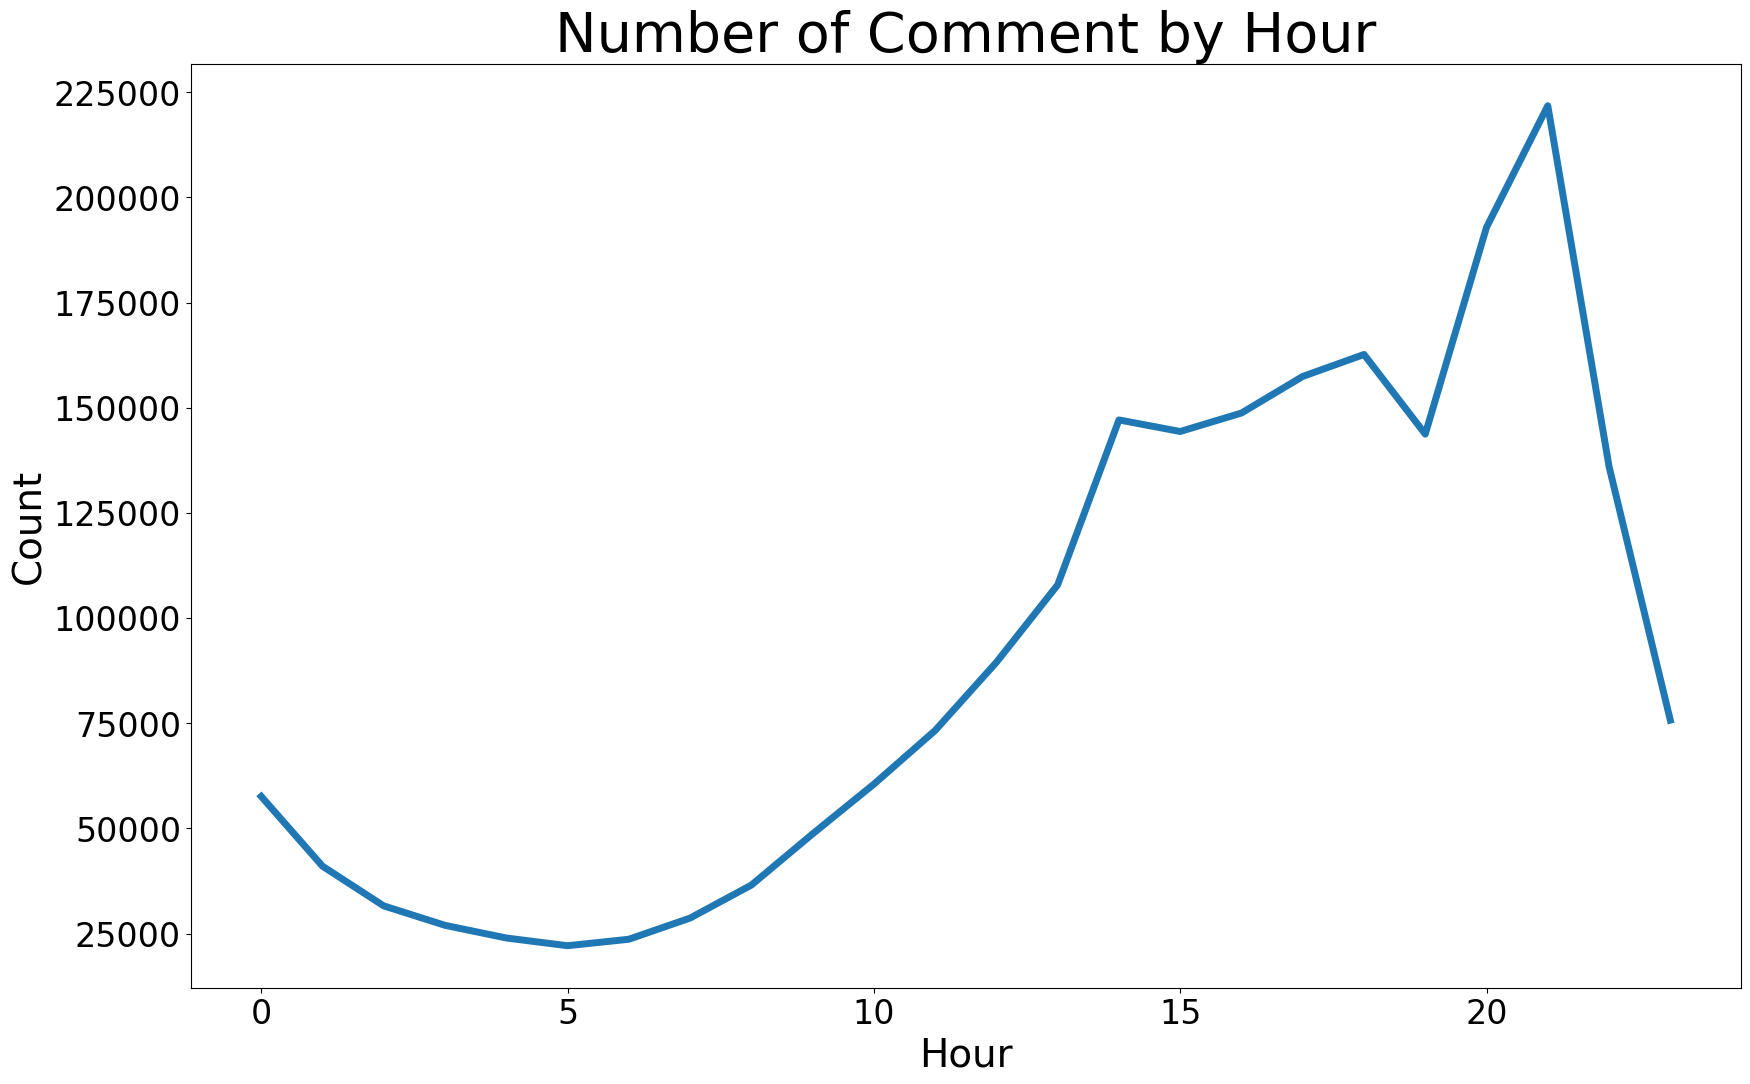

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot lineplot to show the comment number change of a day
plt.figure(figsize=(20, 12))
sns.lineplot(x='hour', y='count', data=hour_count, palette='Set2', linewidth=5)
plt.title('Number of Comment by Hour', fontsize=40)
plt.xlabel('Hour', fontsize=28)
plt.ylabel('Count', fontsize=28)
plt.tick_params(axis='both', labelsize=24)
plt.show()